In [1]:
# load required R packages
# 载入需要的R包
library(tidyverse)
library(DESeq2)
library(BioSeqUtils)
library(caret)
library(randomForest)
library(ROCR) 
library(pROC)
library(ggplot2)
library(PRROC)
library(tidymodels)
library(Seurat)
library(patchwork)
library(ggsci)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:lubridate':

    intersect, setdiff, union


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

   

Warning message:
"package 'Seurat' was built under R version 4.4.3"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.3"

Attaching package: 'sp'


The following object is masked from 'package:IRanges':

    %over%



Attaching package: 'SeuratObject'


The following object is masked from 'package:SummarizedExperiment':

    Assays


The following object is masked from 'package:GenomicRanges':

    intersect


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following object is masked from 'package:IRanges':

    intersect


The following object is masked from 'package:S4Vectors':

    intersect


The following object is masked from 'package:BiocGenerics':

    intersect


The following objects are masked from 'package:base':

    intersect, t


Registered S3 method overwritten by 'spatstat.geom':
  me

In [2]:
#setting working directory
# 设置工作路径
setwd("D:\\project\\白骨壤Cd")

In [3]:
theme_cleveland <- function (rotate = TRUE) 
{
    if (rotate) {
        theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(), 
            panel.grid.major.y = element_line(colour = "grey70", 
                linetype = "dashed"))
    }
}

In [4]:
# custom function for binning sampling method
# 构建函数
binning = function(data, nbin=12, seed1=101, seed2=102){
  # sort fpkm from largest to smallest per gene
  data1 = data %>% arrange(desc(avg_fpkm)) 
  gene_count = nrow(data)
  integer = gene_count%/%nbin
  remainer = gene_count%%nbin
  mysplit = rep(1:nbin,each=integer)
  mysplit = c(mysplit, rep(nbin, remainer))
  split_data = split(data1, mysplit)
  # creating an empty data frame with same column numbers as "data"
  new_data = data.frame(matrix(, nrow=0, ncol=ncol(data1))) 
  colnames(new_data) = colnames(data1)
  for (x in split_data){
    nondeg = x %>% filter(class == 0)
    deg = x %>% filter(class == 1)
    # downsampling between deg and nondeg for cold-responsive genes
    mymin = min(nrow(nondeg), nrow(deg))
    set.seed(seed1)
    new_nondeg = nondeg[sample(mymin),]
    set.seed(seed2)
    new_deg = deg[sample(mymin),]
    new_data = rbind(new_data, new_nondeg, new_deg)
  }
  print (paste("Before binning:",dim(data)[1],sep=""))
  print (paste("After binning:",dim(new_data)[1],sep=""))
  return (new_data)
}

In [5]:
# custom function for differentially expressed genes analysis using DESeq2 R package
# 构建函数，使用DESeq2进行差异表达分析
DEG <- function(count,sampleNames,comparison,rep=3){
    data <- count[,sampleNames]
    countData <- as.matrix(data)
    condition <- c(rep("control",rep),rep("treatment",rep))
    database <- data.frame(name=sampleNames, condition=condition)
    database$condition <- factor(database$condition)
    rownames(database) <- sampleNames
    dds <- DESeqDataSetFromMatrix(countData, colData=database, design= ~ condition)
    dds <- dds[ rowSums(counts(dds)) > 10, ]
    dds <- DESeq(dds)
    res <- results(dds,contrast=c("condition", "treatment", "control"))
    res <- res %>%
        as.data.frame() %>%
        mutate(comparison=comparison,gene=rownames(res))
    return(res)
}

In [6]:
# custom function for reading gene expression in raw counts format
# 读取基因表达数据(格式raw counts)
read_count <- function(path="03_raw_counts/",file="Avicennia_marina.counts"){
    Count <- read.table(paste0(path,file),head=T,check.names = F,row.names=1)
    Count <- Count %>%
        dplyr::select(-c(Chr,Start,End,Strand,Length))
        Cols <- lapply(colnames(Count),function(x){
            unlist(str_split(x,'[-.]'))[3]
        }) 
    colnames(Count) <- unlist(Cols)
    return(Count)
}

In [7]:
# custom function for reading gene expression in FPKM format
# 读取基因表达数据(格式FPKM)
read_fpkm <- function(path="04_TPM_FPKM/",file="Athaliana.fpkm"){
    fpkm <- read.table(paste0(path,file),head=T,check.names = F,row.names=1)
        Cols <- lapply(colnames(fpkm),function(x){
            unlist(str_split(x,'[-.]'))[3]
        }) 
    colnames(fpkm) <- unlist(Cols)
    return(fpkm)
}

In [8]:
# custom a function for negative samples sampling 
# 采用original, random, and binning三种采样的方法
bin_data <- function(deg,lfc,fpkm,feature,meta,method='binning'){
    RG <- deg %>%
            dplyr::filter(abs(log2FoldChange) > lfc & padj < 0.05) %>%
            dplyr::select(gene) %>%
            mutate(class=1)
    NRG <- deg %>%
            dplyr::filter(abs(log2FoldChange) < 0.5) %>%
            dplyr::select(gene) %>%
            mutate(class=0)
    genes <- rbind(RG,NRG)
    avg_fpkm <- deg %>%
        inner_join(genes) %>%
        dplyr::select(gene,class) %>%
        inner_join(fpkm) %>%
        dplyr::select(gene,avg_fpkm,class)
    if(method=="binning"){
        new_data <- binning(avg_fpkm)
    }else if(method=="random"){
        set.seed(123)
        inx <- sample(1:nrow(NRG),nrow(RG))
        NRG <- NRG[inx,]
        genes <- rbind(RG,NRG)
        new_data <- avg_fpkm %>%
                        dplyr::filter(gene %in% genes$gene)       
    }else if(method=="original"){
        new_data <- avg_fpkm
    }
    data <- new_data %>%
        inner_join(feature)
    rownames(data) <- data$gene
    data <- data %>%
                mutate(class=ifelse(class==0,'NRG','RG')) %>%
                dplyr::select(-c(avg_fpkm,gene))
    return(data)
}

In [9]:
# reading gene expression
# 读取基因表达数据
Count <- read_count(path="03_raw_counts/",file="Avicennia_marina.counts")
fpkm <- read_fpkm(path="04_TPM_FPKM//",file="Avicennia_marina.fpkm")

In [10]:
fpkm <- fpkm[,c("Con_2","Con_3","Con_4","Cd_1",'Cd_2','Cd_4')]

In [11]:
fpkm <- data.frame(gene=rownames(fpkm),avg_fpkm=apply(fpkm,1,mean))

In [12]:
Am_deg <- DEG(count=Count,
    sampleNames= c("Con_2","Con_3","Con_4","Cd_1",'Cd_2','Cd_4'),
    comparison=c("Cd"),
          rep=3)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
Am_deg <- Am_deg[!is.na(Am_deg$padj),]

In [14]:
# loading genomics sequence features
# 读取基因特征矩阵
Am <- read.csv("期刊/JHM/revise/Avicennia_marina_feature.csv")
colnames(Am)[1] <- 'gene'

In [15]:
head(Am)

,gene,A.CDS,T.CDS,C.CDS,G.CDS,AA.CDS,AT.CDS,AC.CDS,AG.CDS,TA.CDS,⋯,TC.Down,TG.Down,CA.Down,CT.Down,CC.Down,CG.Down,GA.Down,GT.Down,GC.Down,GG.Down
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Am00001,0.2702703,0.3187599,0.1995231,0.2114467,0.06915739,0.08028617,0.04451510,0.05246423,0.04372019,⋯,0.0535,0.0625,0.0680,0.0470,0.0125,0.0045,0.0420,0.0490,0.0200,0.0255
2,Am00002,0.3083067,0.2678381,0.1975506,0.2263046,0.08572950,0.07241747,0.04313099,0.07880724,0.04472843,⋯,0.0615,0.0680,0.0675,0.0545,0.0390,0.0140,0.0510,0.0515,0.0285,0.0290
3,Am00003,0.2935636,0.2904239,0.2009419,0.2150706,0.08006279,0.08006279,0.03924647,0.07064364,0.04709576,⋯,0.0530,0.0615,0.0640,0.0495,0.0210,0.0100,0.0535,0.0395,0.0215,0.0215
4,Am00004,0.3002681,0.2698838,0.1966041,0.2332440,0.06970509,0.07953530,0.04736372,0.08221626,0.05630027,⋯,0.0290,0.0580,0.0410,0.0300,0.0080,0.0040,0.0440,0.0385,0.0115,0.0100
5,Am00005,0.2771588,0.2458217,0.2284123,0.2486072,0.07172702,0.06058496,0.05431755,0.07103064,0.03760446,⋯,0.0360,0.0520,0.0540,0.0455,0.0275,0.0170,0.0840,0.0495,0.0300,0.0450
6,Am00006,0.2697548,0.2479564,0.2425068,0.2397820,0.07629428,0.05722071,0.04904632,0.06811989,0.02452316,⋯,0.0565,0.0700,0.0710,0.0575,0.0410,0.0300,0.0635,0.0505,0.0490,0.0420


In [16]:
Am2 <- Am %>%
    dplyr::filter(gene %in% Am_deg$gene)

In [17]:
Am_DEG <- Am_deg
Am_DEG <- Am_DEG %>%
    mutate(Organism = "Avicennia marina") %>%
    dplyr::filter(gene %in% Am2$gene)

In [18]:
# data clustering for genomics sequence features
# 对特征序列进行聚类
rownames(Am2) <- Am2$gene
Am2 <- Am2[,-1]
Am2 <- data.frame(t(Am2))
objs <- CreateSeuratObject(counts = Am2, project = "all", meta=Am_deg,min.cells = 1, min.features = 1)
objs <- NormalizeData(objs, normalization.method = "LogNormalize", scale.factor = 30)
objs <- FindVariableFeatures(objs, selection.method = "vst", nfeatures = 3000)
all.genes <- rownames(objs)
objs <- ScaleData(objs, features = all.genes)
objs <- RunPCA(objs,npcs =10, features = VariableFeatures(object = objs))
objs <- FindNeighbors(objs, dims = 1:10)
objs <- FindClusters(objs, resolution = 1)
objs <- RunUMAP(objs, dims = 1:10)

Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  T.Intron, G.Intron, A.Intron, C.Intron, TT.Intron, AT.Intron, TG.Intron, CT.Intron, GT.Intron, GA.Intron 
	   AG.Intron, TA.Intron, TC.Intron, CA.Intron, AA.Intron, AC.Intron, GC.Intron, GG.Intron, CC.Intron, CG.Intron 
	   TA.CDS, AT.CDS, AA.CDS, GG.5UTR, TT.CDS, CC.3UTR, CG.5UTR, TG.CDS, GC.3UTR, CG.Down 
Negative:  G.CDS, C.CDS, T.3UTR, GC.CDS, CG.CDS, GG.CDS, A.Down, T.Up, CC.CDS, T.Down 
	   A.3UTR, TC.CDS, A.Up, GT.Down, AC.Up, C.5UTR, C.Up, CA.Up, TG.Down, GT.Up 
	   CA.5UTR, TT.3UTR, TC.Up, G.Up, G.Down, AT.3UTR, TG.Up, GA.Down, AC.Down, A.5UTR 
PC_ 2 
Positive:  GC.Down, C.Down, CC.Down, G.Down, GG.Down, GC.Up, GG.Up, G.Up, CT.Down, AG.Down 
	   CA.Down, TC.Down, CC.Up, C.Up, CG.Down, GA.Down, C.3UTR, CT.Up, CG.Up, TG.Up 
	   G.5UTR, AG.Up, AC.Down, GA.Up, GC.3UTR, TG.5UTR, TC.Up, GG.5

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25527
Number of edges: 650309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7283
Number of communities: 11
Elapsed time: 5 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:35:02 UMAP embedding parameters a = 0.9922 b = 1.112

14:35:02 Read 25527 rows and found 10 numeric columns

14:35:02 Using Annoy for neighbor search, n_neighbors = 30

14:35:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:35:05 Writing NN index file to temp file C:\Users\jasonxu\AppData\Local\Temp\RtmpoFikQr\file5e201ff97bd0

14:35:05 Searching Annoy index using 1 thread, search_k = 3000

14:35:13 Annoy recall = 100%

14:35:13 Commencing smooth kNN distance calibration using 1 t

# Figure 2A

In [19]:
library(tidydr)

Warning message:
"package 'tidydr' was built under R version 4.4.3"


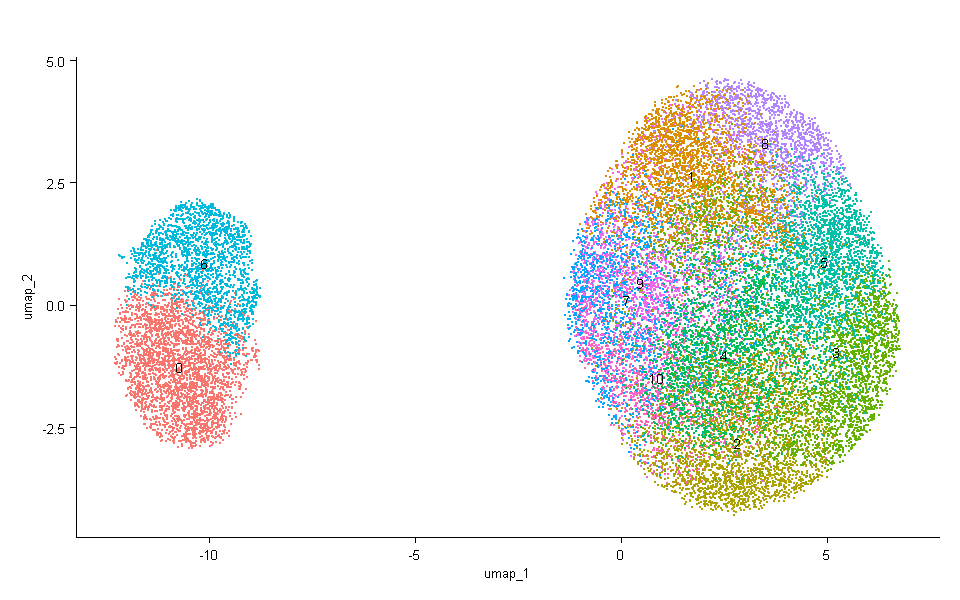

In [20]:
options(repr.plot.width=8, repr.plot.height=5)
Figure2A <- DimPlot(objs,group.by = 'seurat_clusters',label=T, label.size = 3, reduction='umap')+
    ggtitle("")+
    theme(legend.position='none',axis.text=element_text(size=8,color='black'),axis.title=element_text(size=8),
         panel.background = element_blank())
Figure2A

In [21]:
# model evaluation using AUC-ROC
# 计算模型的AUC-ROC
roclist <- NULL
for(type in c('clustering')){
    AUC <- c()
    for(lfc in c(0.5,1,1.5,2)){
        f <- paste0("model/",type,"_log2FC_",lfc,".RData")
        print(f)
        load(f)
        data <- rbind(train,test)
        rf_pred <- predict(rf,test,type="prob")
        predob <- prediction(rf_pred[,2], test$class)
        perf <- performance(predob, 'tpr','fpr')
        perf.auc<- performance(predob, measure = 'auc', x.measure = 'cutoff')
        Auc <- paste0("AUC-ROC: ",sprintf("%.3f",unlist(perf.auc@y.values)))
        print(Auc)
        AUC <- c(AUC,Auc)
        re <- data.frame(x = attributes(perf)$x.values[[1]],
                         y = attributes(perf)$y.values[[1]],
                        type = str_to_title(type),
                        lfc)
        roclist <- rbind(roclist,re)
    }
    AUC <- paste(AUC,collapse = '\n')
}

[1] "model/clustering_log2FC_0.5.RData"
[1] "AUC-ROC: 0.851"
[1] "model/clustering_log2FC_1.RData"
[1] "AUC-ROC: 0.971"
[1] "model/clustering_log2FC_1.5.RData"
[1] "AUC-ROC: 0.989"
[1] "model/clustering_log2FC_2.RData"
[1] "AUC-ROC: 0.968"


# Figure 2B

In [22]:
labels <- data.frame(lfc = c('>0.5','>1','>1.5','>2'),
                       label = AUC)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


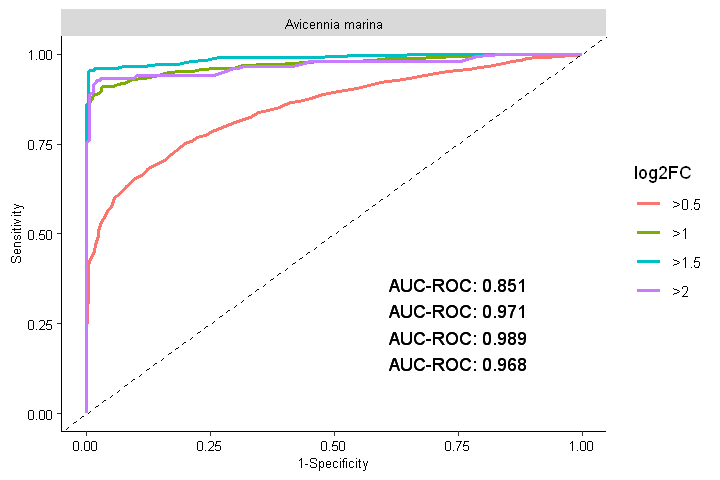

In [23]:
options(repr.plot.width=6, repr.plot.height=4)
Figure2B <- roclist %>%
    mutate(lfc=paste0(">",lfc)) %>%
    mutate(log2FC=factor(lfc)) %>%
    mutate(type="Avicennia marina") %>%
    ggplot()+
    geom_line(aes(x,y,color=log2FC),size = 1) + 
        xlab("1-Specificity") +
        ylab("Sensitivity") +
    facet_grid(~type)+
        theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='right',strip.text.x = element_text(size = 8, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
    geom_text(x = 0.75, y = 0.25, aes(label = label), data = labels)+
geom_abline(intercept = 0, slope = 1,linetype='dashed')
Figure2B

In [24]:
cluster_AUC <- NULL
for(lfc in c(0.5,1,1.5,2)){
    load(paste0("model/clustering_log2FC_",lfc,".RData"))
    for(fea in c('All','Up','5UTR','CDS','Intron','3UTR','Down')){
        print(fea)
        if(fea=="All"){
            sub_train <- train
            sub_test <- test
        }else{
            inx <- which(grepl(fea,colnames(train)))
            sub_train <- train[,c(1,inx)]
            sub_test <- test[,c(1,inx)]
        }
        ctrl <- trainControl(method = "cv",number=10)
        ML_feature <- as.integer(sqrt(ncol(sub_train)-1))
        grid_search = expand.grid(.mtry=ML_feature)
        set.seed(123)
        rf <- train(class ~ ., data = sub_train,
                    method = "rf",
                    ntree = 100,
                    trControl = ctrl,
                    tuneGrid = grid_search)    
        rf_pred <- predict(rf,sub_test,type="prob")
        predob <- prediction(rf_pred[,2], sub_test$class)
        perf.auc<- performance(predob, measure = 'auc', x.measure = 'cutoff')
        Auc <- unlist(perf.auc@y.values)
        re <- data.frame(log2FC=lfc,Feature=fea,Auc)
        cluster_AUC <- rbind(cluster_AUC,re)
    }
}

[1] "All"
[1] "Up"
[1] "5UTR"
[1] "CDS"
[1] "Intron"
[1] "3UTR"
[1] "Down"
[1] "All"
[1] "Up"
[1] "5UTR"
[1] "CDS"
[1] "Intron"
[1] "3UTR"
[1] "Down"
[1] "All"
[1] "Up"
[1] "5UTR"
[1] "CDS"
[1] "Intron"
[1] "3UTR"
[1] "Down"
[1] "All"
[1] "Up"
[1] "5UTR"
[1] "CDS"
[1] "Intron"
[1] "3UTR"
[1] "Down"


# Figure 2D

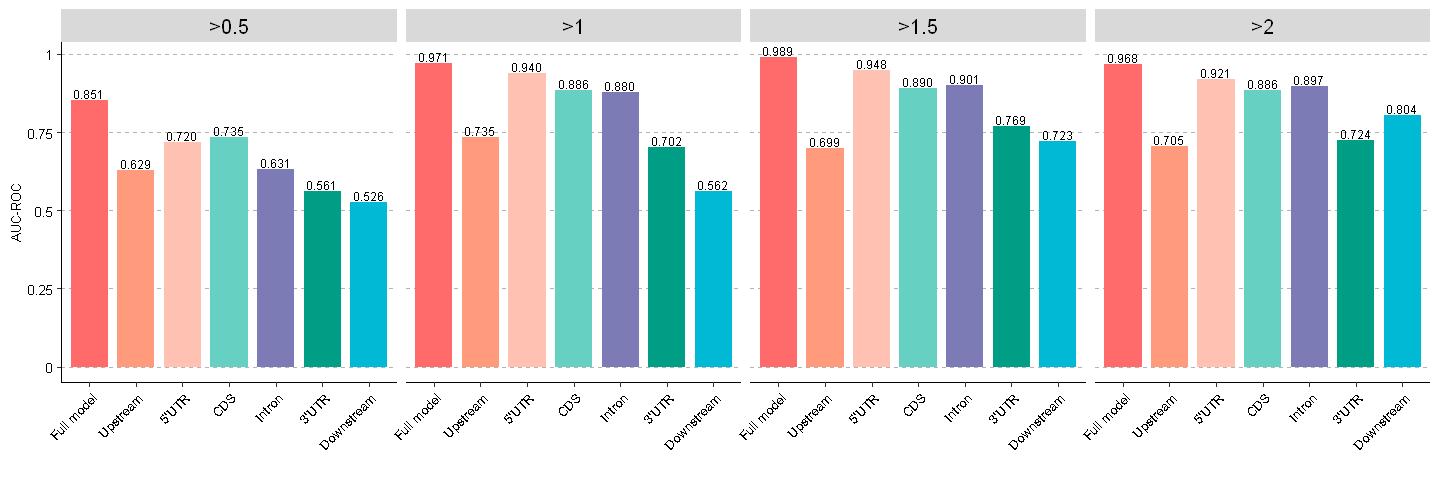

In [25]:
options(repr.plot.width=12, repr.plot.height=4)
Figure2D <- cluster_AUC %>%
    mutate(log2FC=paste0(">",log2FC)) %>%
    mutate(Feature=factor(Feature,levels=c('All','Up',"5UTR",'CDS','Intron',"3UTR",'Down'))) %>%
    mutate(Feature=factor(Feature,labels=c('Full model','Upstream',"5'UTR",'CDS','Intron',"3'UTR",'Downstream'))) %>%
    mutate(Auc2=sprintf("%.3f",Auc)) %>%
    ggplot(aes(Feature,Auc,fill=Feature))+
        geom_bar(stat='identity',width=0.8)+
        geom_text(aes(label=Auc2),size=2.5,position = position_dodge(width = 0.8), vjust = -0.2)+
    facet_grid(~log2FC)+
    theme_cleveland()+
        theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=45,vjust=1,hjust=1),
              panel.background = element_blank(),
              legend.position='none',strip.text = element_text(size = 12, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
xlab('')+ylab('AUC-ROC')+
scale_y_continuous(breaks=seq(0,1,0.25),labels=seq(0,1,0.25))+
scale_fill_manual(values =c('#FF6A6A','#ff9a7d','#ffc2b2','#66d0c2','#7c7bb5','#009f85','#00bad5'))
Figure2D

In [26]:
instance <- NULL
roclist2 <- NULL
AUCs <- c()
for(type in c('original','random','binning')){
    AUC <- c()
    for(lfc in c(0.5,1,1.5,2)){
        f <- paste0("model/",type,"_log2FC_",lfc,".RData")
        print(f)
        load(f)
        data <- rbind(train,test)
        re <- table(data$class) %>%
            as.data.frame() %>%
            mutate(log2FoldChange=lfc) %>%
            mutate(type=str_to_title(type)) %>%
            dplyr::select(Class=Var1,Number=Freq,log2FoldChange,type) 
        instance <- rbind(instance,re)
        rf_pred <- predict(rf,test,type="prob")
        predob <- prediction(rf_pred[,2], test$class)
        perf <- performance(predob, 'tpr','fpr')
        perf.auc<- performance(predob, measure = 'auc', x.measure = 'cutoff')
        Auc <- paste0("AUC-ROC: ",sprintf("%.3f",unlist(perf.auc@y.values)))
        print(Auc)
        AUC <- c(AUC,Auc)
        re <- data.frame(x = attributes(perf)$x.values[[1]],
                         y = attributes(perf)$y.values[[1]],
                        type = str_to_title(type),
                        lfc)
        roclist2 <- rbind(roclist2,re)
    }
    AUC <- paste(AUC,collapse = '\n')
    AUCs <- c(AUCs,AUC)
}

[1] "model/original_log2FC_0.5.RData"
[1] "AUC-ROC: 0.661"
[1] "model/original_log2FC_1.RData"
[1] "AUC-ROC: 0.744"
[1] "model/original_log2FC_1.5.RData"
[1] "AUC-ROC: 0.723"
[1] "model/original_log2FC_2.RData"
[1] "AUC-ROC: 0.745"
[1] "model/random_log2FC_0.5.RData"
[1] "AUC-ROC: 0.659"
[1] "model/random_log2FC_1.RData"
[1] "AUC-ROC: 0.757"
[1] "model/random_log2FC_1.5.RData"
[1] "AUC-ROC: 0.759"
[1] "model/random_log2FC_2.RData"
[1] "AUC-ROC: 0.793"
[1] "model/binning_log2FC_0.5.RData"
[1] "AUC-ROC: 0.647"
[1] "model/binning_log2FC_1.RData"
[1] "AUC-ROC: 0.747"
[1] "model/binning_log2FC_1.5.RData"
[1] "AUC-ROC: 0.733"
[1] "model/binning_log2FC_2.RData"
[1] "AUC-ROC: 0.701"


# Figure S1A

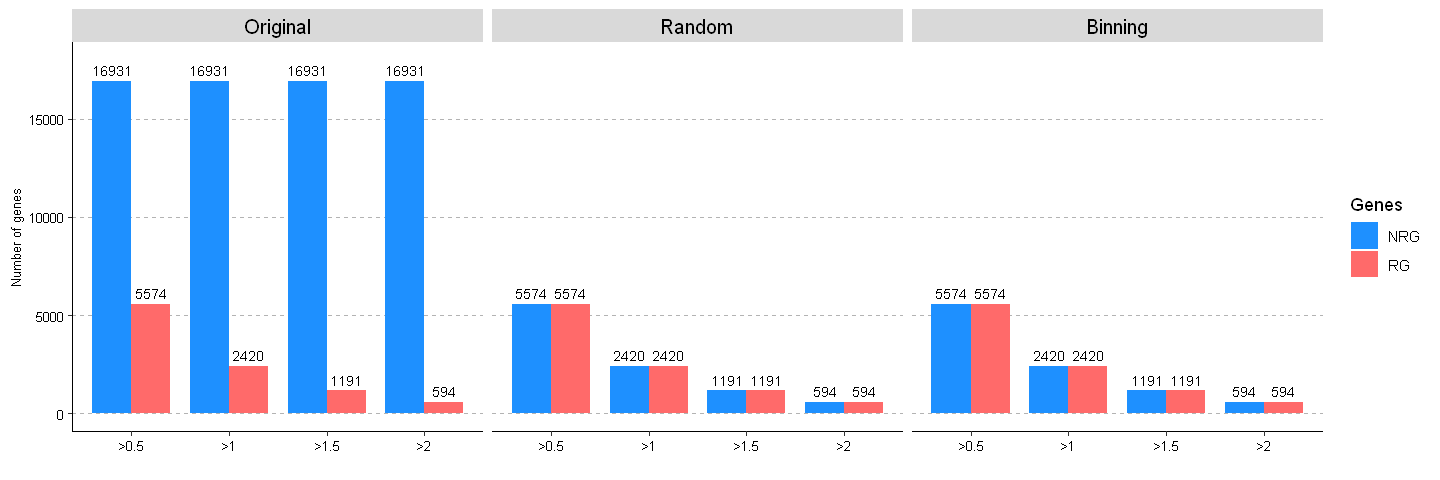

In [27]:
options(repr.plot.width=12, repr.plot.height=4)
FigureS1A <- instance %>%
    mutate(type=factor(type,levels=c('Original','Random','Binning'))) %>%
    mutate(log2FoldChange=paste0(">",log2FoldChange)) %>%
    ggplot(aes(log2FoldChange,Number,fill=Class))+
        geom_bar(stat='identity',width=0.8,position='dodge')+
        geom_text(aes(label=Number),size=3,position = position_dodge(width = 0.8),vjust = -0.5)+
        ylab("Number of genes")+xlab("")+
    theme_cleveland()+
        theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='right',strip.text.x = element_text(size = 12, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
scale_fill_manual(values = c('DodgerBlue1','IndianRed1'))+
guides (fill = guide_legend (title = "Genes"))+
facet_grid(~type)+
ylim(0,18000)
FigureS1A

# Figure S1B

In [28]:
labels2 <- data.frame(type = c('Original','Random','Binning'),
                       label = AUCs)

In [29]:
labels2$type <- factor(labels2$type,levels=c('Original','Random','Binning'))

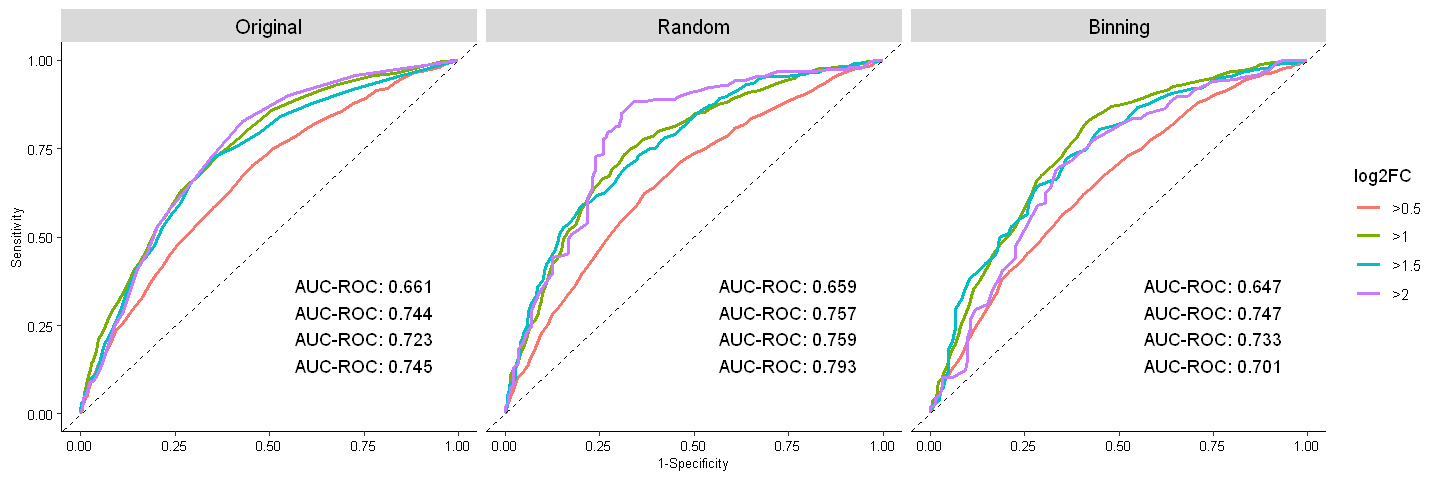

In [30]:
options(repr.plot.width=12, repr.plot.height=4)
FigureS1B <- roclist2 %>%
    mutate(lfc=paste0(">",lfc)) %>%
    mutate(log2FC=factor(lfc)) %>%
    mutate(type=factor(type,levels=c('Original','Random','Binning'))) %>%
    ggplot()+
    geom_line(aes(x,y,color=log2FC),size = 1) + 
        xlab("1-Specificity") +
        ylab("Sensitivity") +
    facet_grid(~type)+
        theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              panel.background = element_blank(),
              legend.position='right',strip.text.x = element_text(size = 12, colour = "black"),
              #strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
    geom_text(x = 0.75, y = 0.25, aes(label = label), data = labels2)+
geom_abline(intercept = 0, slope = 1,linetype='dashed')
FigureS1B